<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>MLOps e Ciclo de Vida de Modelos de Machine Learning</font>
## <font color='blue'>Projeto 1</font>
### <font color='blue'>MLOps Stack Para Otimização de Hiperparâmetros com MLflow e Optuna</font>

## Instalação, Carregamento e Gerenciamento de Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

Não é necessário instalar os pacotes abaixo, pois eles já estão no arquivo requirements.txt. Leia as instruções no arquivo LEIAME.txt.

In [2]:
#!pip install -q optuna

In [3]:
#!pip install -q mlflow

In [4]:
#!pip install -q xgboost

In [5]:
# Imports
import json
import math
import sklearn
import optuna
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" 

Author: Data Science Academy



## Inicializando o Servidor MLflow

Abra um prompt de comando ou terminal, navegue até a pasta do projeto, ative o ambiente virtual (instruções no LEIAME.txt) e digite o comando abaixo:

mlflow server --host 127.0.0.1 --port 8282

> Agora conectamos no servidor MLflow:

In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:8282")

Acesse a url acima a partir de outra aba no seu navegador: http://127.0.0.1:8282

## Carregando e Compreendendo os Dados

In [8]:
# Carrega o dataset
df_dsa = pd.read_csv("dataset.csv")

In [9]:
# Shape
df_dsa.shape

(5000, 11)

In [10]:
# Amostra dos dados
df_dsa.head()

,data,temperatura_media,precipitacao,fim_de_semana,feriado,preco_por_kg,promocao,demanda,demanda_dos_dias_anteriores,preco_por_kg_do_concorrente,intensidade_de_marketing
0,2010-10-18 09:16:07.883826,30.584727,1.199291,0,0,1.726258,1,1051.375336,1051.276659,1.935346,0.098677
1,2010-10-19 09:16:07.883825,15.465069,1.037626,0,0,0.576471,1,1106.855943,1051.276659,2.344720,0.019318
2,2010-10-20 09:16:07.883824,10.786525,5.656089,0,0,2.513328,1,1008.304909,1106.836626,0.998803,0.409485
3,2010-10-21 09:16:07.883823,23.648154,12.030937,0,0,1.839225,1,999.833810,1057.895424,0.761740,0.872803
4,2010-10-22 09:16:07.883822,13.861391,4.303812,0,0,1.531772,1,1183.949061,1048.961007,2.123436,0.820779


In [11]:
# Tipos dos dados
df_dsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   data                         5000 non-null   object 
 1   temperatura_media            5000 non-null   float64
 2   precipitacao                 5000 non-null   float64
 3   fim_de_semana                5000 non-null   int64  
 4   feriado                      5000 non-null   int64  
 5   preco_por_kg                 5000 non-null   float64
 6   promocao                     5000 non-null   int64  
 7   demanda                      5000 non-null   float64
 8   demanda_dos_dias_anteriores  5000 non-null   float64
 9   preco_por_kg_do_concorrente  5000 non-null   float64
 10  intensidade_de_marketing     5000 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 429.8+ KB


In [12]:
# Vamos ajustar a coluna de data para o tipo correto
df_dsa['data'] = pd.to_datetime(df_dsa['data'])

In [13]:
# Tipos dos dados
df_dsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   data                         5000 non-null   datetime64[ns]
 1   temperatura_media            5000 non-null   float64       
 2   precipitacao                 5000 non-null   float64       
 3   fim_de_semana                5000 non-null   int64         
 4   feriado                      5000 non-null   int64         
 5   preco_por_kg                 5000 non-null   float64       
 6   promocao                     5000 non-null   int64         
 7   demanda                      5000 non-null   float64       
 8   demanda_dos_dias_anteriores  5000 non-null   float64       
 9   preco_por_kg_do_concorrente  5000 non-null   float64       
 10  intensidade_de_marketing     5000 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)


In [14]:
# Resumo estatístico
df_dsa.describe()

,data,temperatura_media,precipitacao,fim_de_semana,feriado,preco_por_kg,promocao,demanda,demanda_dos_dias_anteriores,preco_por_kg_do_concorrente,intensidade_de_marketing
count,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2017-08-21 21:16:07.881014528,22.433182,4.962877,0.285600,0.033000,1.758228,0.289000,1258.452333,1282.446665,1.769682,0.848173
min,2010-10-18 09:16:07.883826,10.002439,0.000071,0.000000,0.000000,0.500360,0.000000,707.952882,757.216503,0.500754,0.019318
25%,2014-03-21 03:16:07.882367232,16.311898,1.440718,0.000000,0.000000,1.134110,0.000000,1066.040653,1089.993191,1.160719,0.773080
50%,2017-08-21 21:16:07.881031424,22.400265,3.520515,0.000000,0.000000,1.776194,0.000000,1222.237635,1244.619215,1.764809,0.848107
75%,2021-01-22 15:16:07.879706624,28.570768,6.805668,1.000000,0.000000,2.383638,1.000000,1422.792698,1445.791858,2.401827,0.928536
max,2024-06-25 09:16:07.878116,34.995334,40.072693,1.000000,1.000000,2.999606,1.000000,2183.463942,2182.608701,2.999847,0.999979
std,NaN,7.146610,4.932382,0.451745,0.178654,0.725334,0.453343,253.240475,249.087488,0.721041,0.093135


<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Carregando e Compreendendo os Metadados (Dicionário)

In [15]:
# Carrega o arquivo JSON
with open('dicionario_de_dados.json', 'r') as arquivo:
    dicionario_de_dados = json.load(arquivo)

In [16]:
# Cria um DataFrame a partir do dicionário de metadados
df_dict = pd.DataFrame.from_dict(dicionario_de_dados, orient = 'index')

In [17]:
# Não truncar colunas no Pandas
pd.set_option('display.max_colwidth', None)

In [18]:
df_dict

,descrição,tipo
data,Data e hora em que os dados foram registrados.,datetime
temperatura_media,Temperatura média registrada na data.,float
precipitacao,Quantidade de precipitação registrada na data.,float
fim_de_semana,Indica se o dia é um fim de semana (1) ou não (0).,int
feriado,Indica se o dia é um feriado (1) ou não (0).,int
preco_por_kg,Preço por kg do produto vendido.,float
promocao,Indica se havia uma promoção ativa (1) ou não (0).,int
demanda,Demanda do produto na data.,float
demanda_dos_dias_anteriores,Demanda do produto no dia anterior.,float
preco_por_kg_do_concorrente,Preço por kg do produto oferecido por um concorrente.,float


<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Funções de Exploração e Visualização dos Dados Para o Experimento

In [19]:
# Função para o plot da correlação das variáveis preditoras com a variável alvo (demanda)
def dsa_plot_corr_demanda(df, save_path = None):

    # Calcula as correlações das variáveis com a demanda, exceto a própria demanda
    correlations = df.corr()["demanda"].drop("demanda").sort_values()

    # Define uma paleta de cores divergentes
    colors = sns.diverging_palette(10, 130, as_cmap = True)
    
    # Mapeia as cores às correlações
    color_mapped = correlations.map(colors)

    # Define o estilo do gráfico
    sns.set_style("darkgrid", {"axes.facecolor": "#eaeaf2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de barras horizontais para as correlações
    plt.barh(correlations.index, correlations.values, color = color_mapped)

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Correlação com Demanda", fontsize = 16)
    plt.xlabel("Coeficiente de Correlação", fontsize = 14)
    plt.ylabel("Variável", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.grid(axis="x")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

In [20]:
# Executa a função
dsa_grafico1 = dsa_plot_corr_demanda(df_dsa)

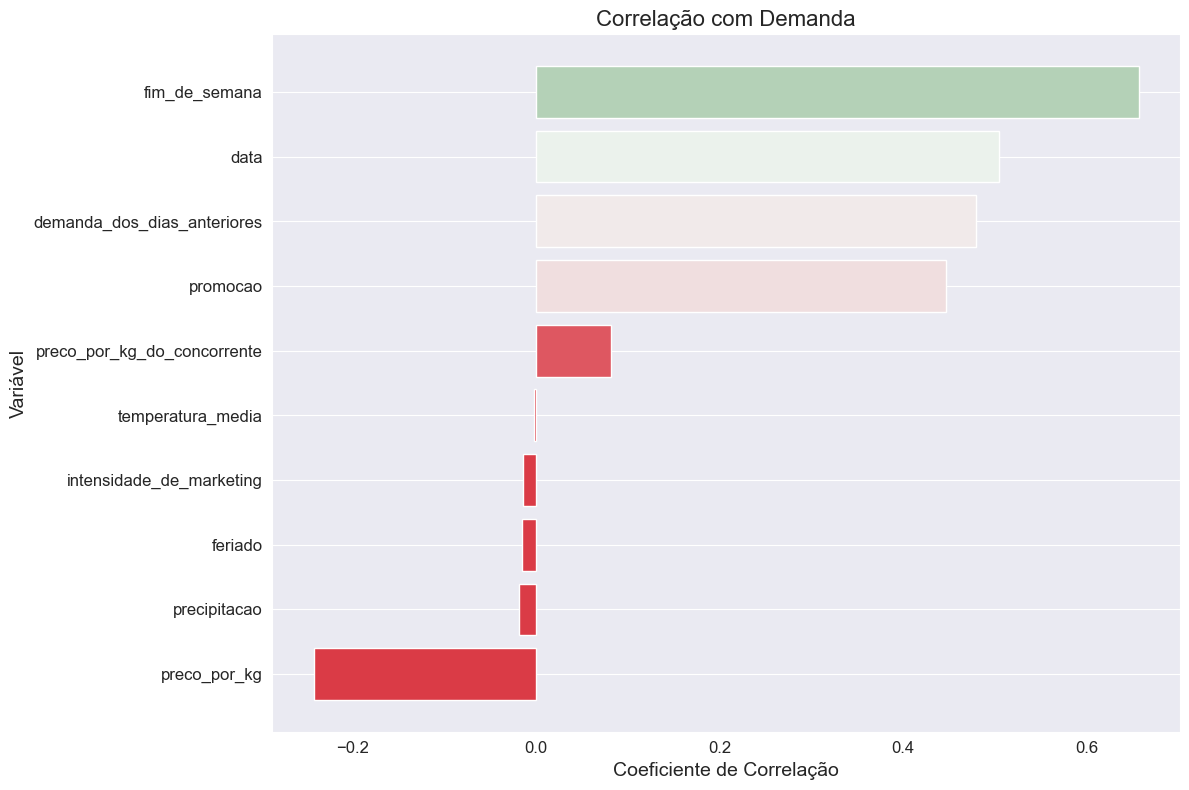

In [21]:
dsa_grafico1

In [22]:
# Função para plot dos resíduos do modelo
def dsa_plot_residuos(model, dvalid, valid_y, save_path = None):

    # Faz as previsões no conjunto de validação
    preds = model.predict(dvalid)

    # Calcula os resíduos (diferença entre valores reais e previstos)
    residuals = valid_y - preds

    # Define o estilo do gráfico para 'whitegrid'
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Cria a figura do plot com tamanho definido
    fig = plt.figure(figsize = (12, 8))
    
    # Cria um gráfico de dispersão dos valores reais versus resíduos
    plt.scatter(valid_y, residuals, color = "blue", alpha = 0.5)
    
    # Adiciona uma linha horizontal em y=0
    plt.axhline(y = 0, color = "r", linestyle = "-")

    # Define o título e os rótulos dos eixos do gráfico
    plt.title("Resíduos x Valores Reais", fontsize = 16)
    plt.xlabel("Valores Reais", fontsize = 14)
    plt.ylabel("Resíduos", fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.grid(axis = "y")

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()

    # Salva o gráfico como um arquivo PNG, se um caminho for fornecido
    if save_path:
        plt.savefig(save_path, format = "png", dpi = 600)

    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

In [23]:
# Função para plot da importância das variáveis
def dsa_plot_feature_importance(model, booster):

    # Cria a figura e o eixo para o plot com tamanho definido
    fig, ax = plt.subplots(figsize = (10, 8))
    
    # Define o tipo de importância como "weight" se o booster for "gblinear", caso contrário "gain"
    importance_type = "weight" if booster == "gblinear" else "gain"
    
    # Plot das importância das variáveis usando o XGBoost
    xgb.plot_importance(model,
                        importance_type = importance_type,
                        ax = ax,
                        title = f"Feature Importance baseada em {importance_type}")
    
    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    
    # Fecha a figura para liberar memória
    plt.close(fig)

    # Retorna a figura criada
    return fig

## Criando o Experimento no MLflow

In [24]:
# Função para criar o experimento
def dsa_cria_experimento(experiment_name):

    # Verifica se o experimento já existe pelo nome
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # Se o experimento existir, retorna seu ID
        return experiment.experiment_id
    else:
        # Se o experimento não existir, cria um novo e retorna seu ID
        return mlflow.create_experiment(experiment_name)

In [25]:
# Cria o experimento
id_experimento_dsa_p1 = dsa_cria_experimento("DSAProjeto1")

In [26]:
# Experimento criado
id_experimento_dsa_p1

'666029664719613320'

Visualize no seu navegador: http://127.0.0.1:8282

In [27]:
# Define o experimento MLflow ativo atual
mlflow.set_experiment(experiment_id = id_experimento_dsa_p1)

<Experiment: artifact_location='mlflow-artifacts:/666029664719613320', creation_time=1752538804911, experiment_id='666029664719613320', last_update_time=1752538804911, lifecycle_stage='active', name='DSAProjeto1', tags={}>

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
## Pré-Processamento dos Dados Para o Experimento

Acompanhe o videobook no Capítulo 6 do curso.

In [28]:
# Separa em X e y
X = df_dsa.drop(columns = ["data", "demanda"])
y = df_dsa["demanda"]

In [29]:
# Divide os dados em treino e validação
x_treino, x_valid, y_treino, y_valid = train_test_split(X, y, test_size = 0.25)

In [30]:
# Coloca os dados no formato de matriz do XGBoost
dsa_treino = xgb.DMatrix(x_treino, label = y_treino)
dsa_valid = xgb.DMatrix(x_valid, label = y_valid)

In [31]:
# Substitui o registro padrão do Optuna apenas para ERROR
optuna.logging.set_verbosity(optuna.logging.ERROR)

## Definindo o Callback de Logging

Registro de retorno de chamada que informará quando uma nova iteração de teste melhorar a existente.

In [32]:
# Função de callback
def dsa_callback(study, frozen_trial):

    # Obtém o valor atual do "winner" (vencedor) dos atributos do estudo
    winner = study.user_attrs.get("winner", None)

    # Verifica se há um novo melhor valor e se o "winner" não é igual ao melhor valor
    if study.best_value and winner != study.best_value:
        
        # Define o novo melhor valor como "winner"
        study.set_user_attr("winner", study.best_value)
        
        # Se havia um "winner" anterior
        if winner:
            
            # Calcula a porcentagem de melhoria em relação ao "winner" anterior
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            
            # Imprime o número da tentativa, o valor alcançado e a porcentagem de melhoria
            print(
                f"Tentativa {frozen_trial.number} alcançou o valor: {frozen_trial.value} com "
                f"{improvement_percent: .4f}% de melhora na métrica de avaliação.")
        else:
            # Se não havia um "winner" anterior, imprime o número da tentativa inicial e o valor alcançado
            print(
                f"Tentativa inicial {frozen_trial.number} alcançou o valor: "
                f"{frozen_trial.value} na métrica de avaliação.")

## Definindo os Hiperparâmetros do XGBoost Para o Experimento

Acompanhe o videobook no Capítulo 6 do curso.

In [33]:
# Função para definir os hiperparâmetros que serão otimizados
def dsa_otimiza_hiperparametro(trial):
    
    # Inicia uma nova execução de MLflow
    with mlflow.start_run(nested = True):
        
        # Define os hiperparâmetros básicos do modelo
        params = {
            
            # Função alvo (objetivo)
            "objective": "reg:squarederror",
            
            # Métrica de avaliação
            "eval_metric": "rmse",
            
            # Tipo de booster (algoritmo de treinamento)
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            
            # Valor de lambda para regularização L2
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log = True),
            
            # Valor de alpha para regularização L1
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log = True),
        }

        # Se o booster for 'gbtree' ou 'dart', adiciona parâmetros específicos
        if params["booster"] == "gbtree" or params["booster"] == "dart":
            
            # Profundidade máxima da árvore
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            
            # Valor de eta (taxa de aprendizado)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            
            # Valor de gamma para regularização adicional
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            
            # Política de crescimento das árvores
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Treina o modelo com os hiperparâmetros escolhidos
        bst = xgb.train(params, dsa_treino)
        
        # Faz previsões no conjunto de validação
        preds = bst.predict(dsa_valid)
        
        # Calcula o erro quadrático médio
        error = mean_squared_error(y_valid, preds)

        # Registra os parâmetros no MLflow
        mlflow.log_params(params)
        
        # Registra o MSE no MLflow
        mlflow.log_metric("mse", error)
        
        # Registra o RMSE no MLflow
        mlflow.log_metric("rmse", math.sqrt(error))

    # Retorna o erro calculado
    return error

## Executando o Experimento com MLflow e Optuna

In [34]:
# Nome para a execução no MLflow
run_name = "dsa_p1"

In [35]:
# Inicia a execução de ajuste de hiperparâmetros
with mlflow.start_run(experiment_id = id_experimento_dsa_p1, run_name = run_name, nested = True):
    
    # Cria um estudo Optuna para otimização de hiperparâmetros para minimizar a função alvo (função de erro)
    study = optuna.create_study(direction = "minimize")

    # Otimiza os hiperparâmetros com 500 tentativas, usando a função de callback
    study.optimize(dsa_otimiza_hiperparametro, n_trials = 500, callbacks = [dsa_callback])

    # Registra os melhores hiperparâmetros encontrados no MLflow
    mlflow.log_params(study.best_params)
    
    # Registra o melhor valor de MSE encontrado no MLflow
    mlflow.log_metric("best_mse", study.best_value)
    
    # Calcula e registra o melhor valor de RMSE no MLflow
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Define tags para a execução no MLflow
    mlflow.set_tags(tags = {"project": "DSA MLOps Projeto 1",
                            "optimizer_engine": "optuna",
                            "model_family": "xgboost",
                            "feature_set_version": 1})

    # Treina o modelo com os melhores parâmetros encontrados
    model = xgb.train(study.best_params, dsa_treino)

    # Registra o gráfico dsa_grafico1 no MLflow
    mlflow.log_figure(figure = dsa_grafico1, artifact_file = "dsa_grafico1.png")

    # Plota e registra a importância das variáveis no MLflow
    importances = dsa_plot_feature_importance(model, booster = study.best_params.get("booster"))
    mlflow.log_figure(figure = importances, artifact_file = "dsa_grafico2.png")

    # Plota e registra os resíduos no MLflow
    residuals = dsa_plot_residuos(model, dsa_valid, y_valid)
    mlflow.log_figure(figure = residuals, artifact_file = "dsa_grafico3.png")

    # Define o caminho do artefato do modelo
    artifact_path = "model"

    # Registra o modelo treinado no MLflow
    mlflow.xgboost.log_model(xgb_model = model,
                             artifact_path = artifact_path,
                             input_example = x_treino.iloc[[0]],
                             model_format = "ubj",
                             metadata = {"model_data_version": 1})

    # Obtém a URI do artefato do modelo registrado
    model_uri = mlflow.get_artifact_uri(artifact_path)

Tentativa inicial 0 alcançou o valor: 20422.533886728077 na métrica de avaliação.
Tentativa 19 alcançou o valor: 18535.887188363475 com  10.1783% de melhora na métrica de avaliação.
Tentativa 21 alcançou o valor: 17604.02100565272 com  5.2935% de melhora na métrica de avaliação.
Tentativa 23 alcançou o valor: 16068.901216867704 com  9.5534% de melhora na métrica de avaliação.
Tentativa 73 alcançou o valor: 15898.133067395567 com  1.0741% de melhora na métrica de avaliação.


Visualize no seu navegador: http://127.0.0.1:8282

## Carregando o Modelo a Partir dos Artefatos

In [36]:
# Caminho para o melhor modelo (com melhor combinação de hiperparâmetros) salvo em disco
model_uri

'mlflow-artifacts:/666029664719613320/db6168d4e0d845e087a3df38ea3673da/artifacts/model'

In [37]:
# Carrega o melhor modelo do disco
dsa_melhor_modelo = mlflow.xgboost.load_model(model_uri)

## Pipeline de Inferência com o Melhor Modelo

In [38]:
# Gera um batch de dados a partir de X (variáveis preditoras)
batch_dmatrix = xgb.DMatrix(X)

In [39]:
# Faz a inferência (previsões) usando o melhor modelo - ATENÇÃO: ISSO NÃO É DEPLOY!!!!
inferencia = dsa_melhor_modelo.predict(batch_dmatrix)

In [40]:
# Cria cópia do dataframe original
df_final = df_dsa.copy()

In [41]:
# Cria uma coluna com as previsões
df_final["demanda_prevista"] = inferencia

In [42]:
df_final.sample(10)

,data,temperatura_media,precipitacao,fim_de_semana,feriado,preco_por_kg,promocao,demanda,demanda_dos_dias_anteriores,preco_por_kg_do_concorrente,intensidade_de_marketing,demanda_prevista
4592,2023-05-15 09:16:07.878631,16.435938,2.297567,0,0,1.787217,0,1397.509346,1697.851391,2.977776,0.839813,1232.645386
2609,2017-12-09 09:16:07.880917,19.633283,1.887934,1,0,1.267494,1,1772.677166,1166.779492,1.574871,0.951543,1698.428467
4806,2023-12-15 09:16:07.878363,10.595565,0.147658,0,1,1.548279,0,1404.377106,1396.606930,2.724420,0.759412,1192.072998
2060,2016-06-08 09:16:07.881495,13.326322,5.029255,0,0,2.059750,0,1062.873594,1162.117299,2.877723,0.741212,1109.247437
2511,2017-09-02 09:16:07.881019,25.257899,4.714841,1,0,2.444000,1,1680.866379,956.416722,0.836535,0.860363,1443.062622
2074,2016-06-22 09:16:07.881480,32.511208,5.088841,0,0,2.754245,0,927.839980,1109.170529,2.477093,0.957327,1009.354553
2387,2017-05-01 09:16:07.881149,10.638434,5.734760,0,0,0.796339,0,1248.031418,1702.264736,2.300065,0.793096,1243.677002
2073,2016-06-21 09:16:07.881481,29.106206,11.917328,0,0,0.782798,0,1110.142826,1152.131435,2.961303,0.972297,1202.096313
2994,2018-12-29 09:16:07.880514,10.230699,5.296083,1,0,2.161760,0,1399.687749,1110.333421,1.444081,0.781517,1374.773193
2507,2017-08-29 09:16:07.881023,23.919676,3.205105,0,0,1.613116,1,1270.202543,980.270547,1.220012,0.779937,1237.531128


Projeto concluído com sucesso! Cliente feliz. Partimos para o próximo projeto.

In [43]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [44]:
#%watermark -v -m

In [45]:
#%watermark --iversions

# Fim